In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jet-quark-gluon/quark-gluon_data-set_n139306.hdf5


In [60]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('ggplot')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [61]:
file_path = '/kaggle/input/jet-quark-gluon/quark-gluon_data-set_n139306.hdf5'

# Load all data from HDF5 file
with h5py.File(file_path, 'r') as f:
    print("Available keys in the HDF5 file:")
    print(list(f.keys()))
    
    print("\nDataset shapes:")
    print(f"X_jets shape: {f['X_jets'].shape}")
    print(f"y shape: {f['y'].shape}")

Available keys in the HDF5 file:
['X_jets', 'm0', 'pt', 'y']

Dataset shapes:
X_jets shape: (139306, 125, 125, 3)
y shape: (139306,)


Using a sample from the whole dataset to train and evaluate the model, because of lack of free resources.

In [62]:
def sample_from_hdf5(file_path, n_samples=100000, random_seed=42):
    np.random.seed(random_seed)
    with h5py.File(file_path, 'r') as f:
        total_samples = f['X_jets'].shape[0]
        indices = np.random.choice(total_samples, size=n_samples, replace=False)
        indices.sort()  # Improve read performance
        
        # Initialize arrays
        X_sample = np.empty((n_samples, 125, 125, 3), dtype=np.float32)
        y_sample = np.empty(n_samples, dtype=np.int8)
        
        # Read in chunks
        chunk_size = 2000
        for i in range(0, n_samples, chunk_size):
            chunk_indices = indices[i:i+chunk_size]
            X_sample[i:i+chunk_size] = f['X_jets'][chunk_indices]
            y_sample[i:i+chunk_size] = f['y'][chunk_indices]
            
    return X_sample, y_sample

X_sample, y_sample = sample_from_hdf5(file_path, n_samples=20000)
print(f"\nSampled data shapes:")
print(f"X_sample: {X_sample.shape}")
print(f"y_sample: {y_sample.shape}")
print(f"Class distribution: {np.unique(y_sample, return_counts=True)}")


Sampled data shapes:
X_sample: (20000, 125, 125, 3)
y_sample: (20000,)
Class distribution: (array([0, 1], dtype=int8), array([10087,  9913]))


In [63]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\nFinal split sizes:")
print(f"Train: {X_train.shape[0]} samples ")
print(f"Validation: {X_val.shape[0]} samples ")
print(f"Test: {X_test.shape[0]} samples ")
print(f"\nClass distribution in Train: {np.unique(y_train, return_counts=True)}")
print(f"Class distribution in Val: {np.unique(y_val, return_counts=True)}")
print(f"Class distribution in Test: {np.unique(y_test, return_counts=True)}")


Final split sizes:
Train: 16000 samples 
Validation: 2000 samples 
Test: 2000 samples 

Class distribution in Train: (array([0, 1], dtype=int8), array([8070, 7930]))
Class distribution in Val: (array([0, 1], dtype=int8), array([1008,  992]))
Class distribution in Test: (array([0, 1], dtype=int8), array([1009,  991]))


In [64]:
def normalize_channels(data):
    normalized = np.empty_like(data, dtype=np.float32)
    for i in range(3):  
        channel = data[..., i]
        normalized[..., i] = (channel - channel.min()) / (channel.max() - channel.min())
    return normalized

X_train_norm = normalize_channels(X_train)
X_val_norm = normalize_channels(X_val)

In [65]:
train_data = torch.tensor(X_train_norm, dtype=torch.float32).permute(0, 3, 1, 2)  # NCHW format
val_data = torch.tensor(X_val_norm, dtype=torch.float32).permute(0, 3, 1, 2)

train_loader = DataLoader(TensorDataset(train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data), batch_size=64)

In [ ]:
class JetAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),  # 125 -> 63
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # 63 -> 32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # 16 -> 8
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1,  output_padding=1),  # 8 -> 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1,  output_padding=1),  # 16 -> 32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2),  # 32 -> 63
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2),  # 63 -> 125
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = JetAutoencoder().to(device)
print(model)

JetAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(

In [68]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Lower learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [69]:
def train_epoch(model, dataloader):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
    return running_loss / len(dataloader)

num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = validate(model, val_loader)
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')


Epoch 1/20 - Train Loss: 0.00759815, Val Loss: 0.00025021
Epoch 2/20 - Train Loss: 0.00015089, Val Loss: 0.00010149
Epoch 3/20 - Train Loss: 0.00006754, Val Loss: 0.00007109
Epoch 4/20 - Train Loss: 0.00004069, Val Loss: 0.00004992
Epoch 5/20 - Train Loss: 0.00002818, Val Loss: 0.00004121
Epoch 6/20 - Train Loss: 0.00002153, Val Loss: 0.00003535
Epoch 7/20 - Train Loss: 0.00004059, Val Loss: 0.00003700
Epoch 8/20 - Train Loss: 0.00001790, Val Loss: 0.00002521
Epoch 9/20 - Train Loss: 0.00001275, Val Loss: 0.00001998
Epoch 10/20 - Train Loss: 0.00001102, Val Loss: 0.00001729
Epoch 11/20 - Train Loss: 0.00001023, Val Loss: 0.00001639
Epoch 12/20 - Train Loss: 0.00001027, Val Loss: 0.00001546
Epoch 13/20 - Train Loss: 0.00001064, Val Loss: 0.00001866
Epoch 14/20 - Train Loss: 0.00001105, Val Loss: 0.00001719
Epoch 15/20 - Train Loss: 0.00001136, Val Loss: 0.00001659
Epoch 16/20 - Train Loss: 0.00001161, Val Loss: 0.00001841
Epoch 17/20 - Train Loss: 0.00001175, Val Loss: 0.00001870
Epoch 

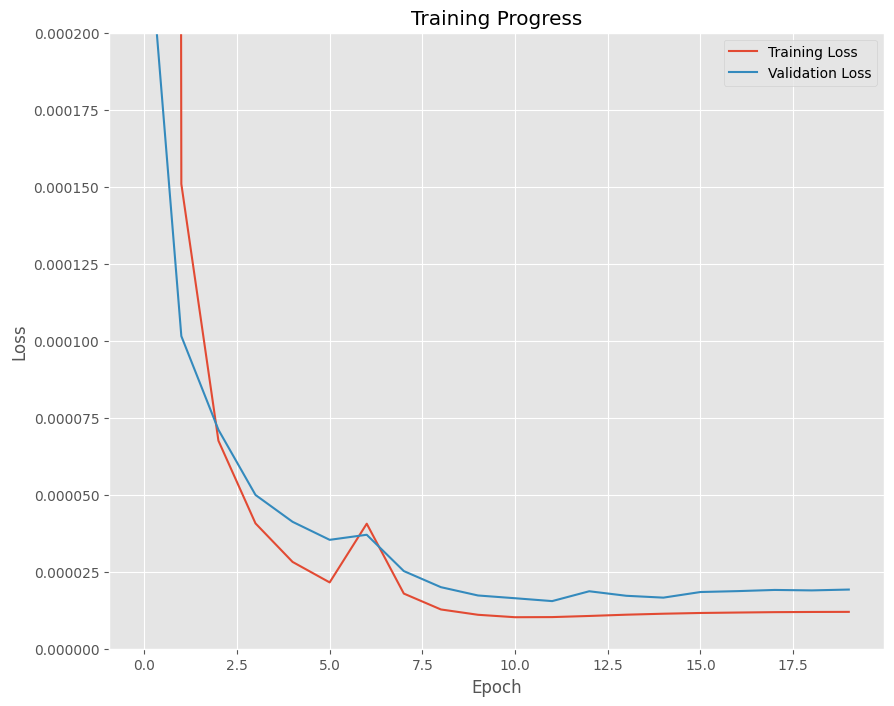

In [70]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.0002)
plt.show()

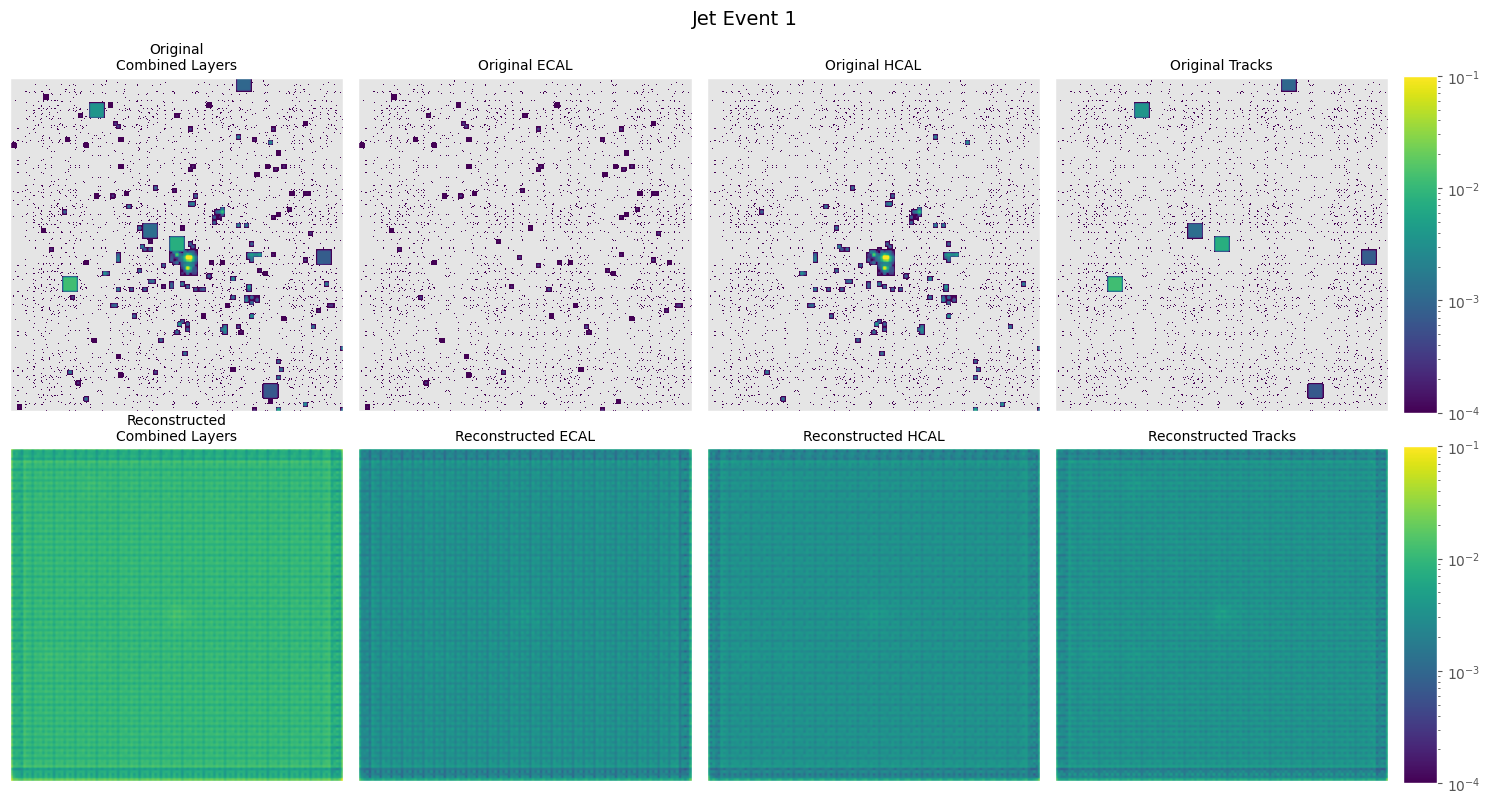

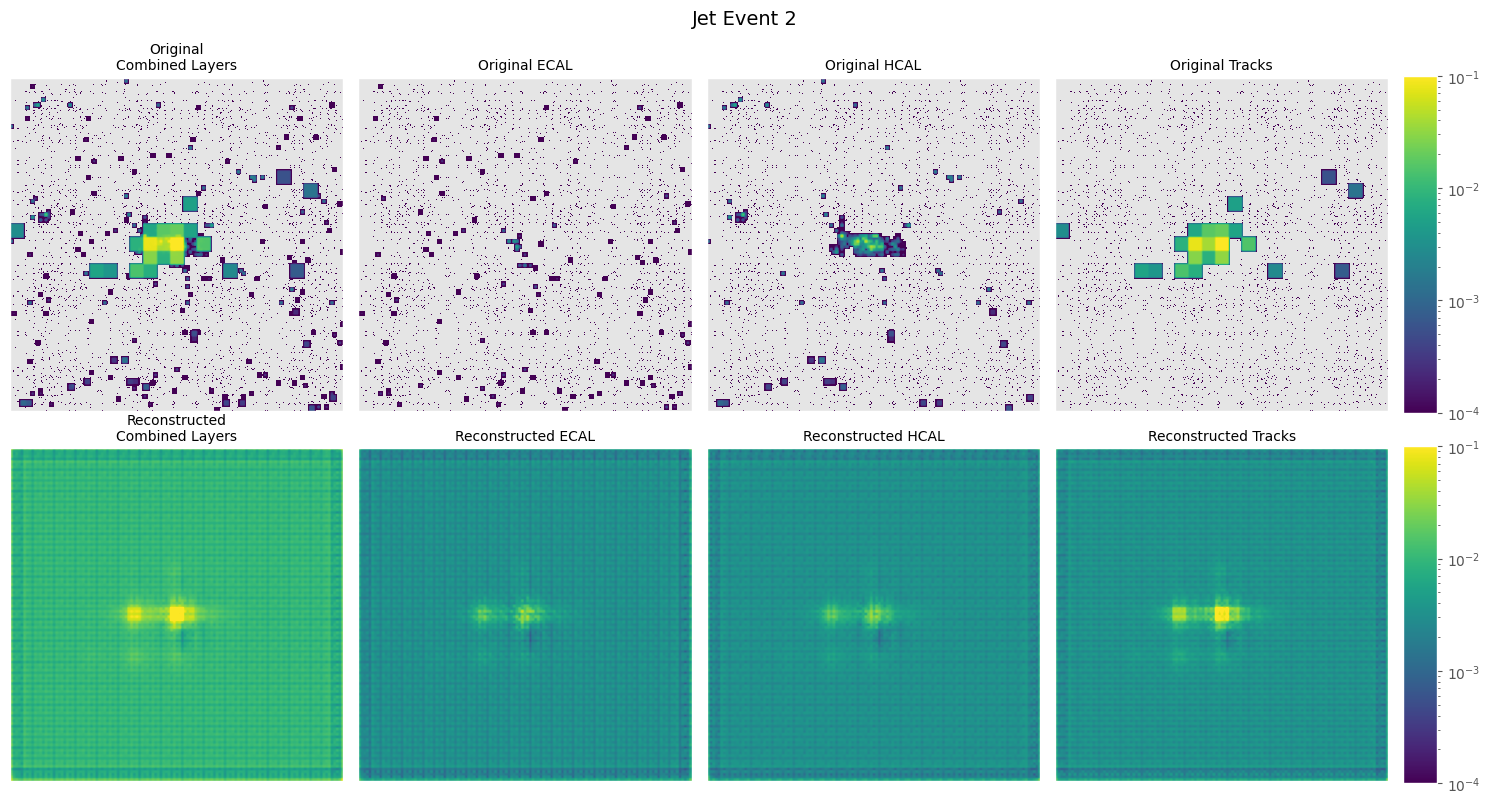

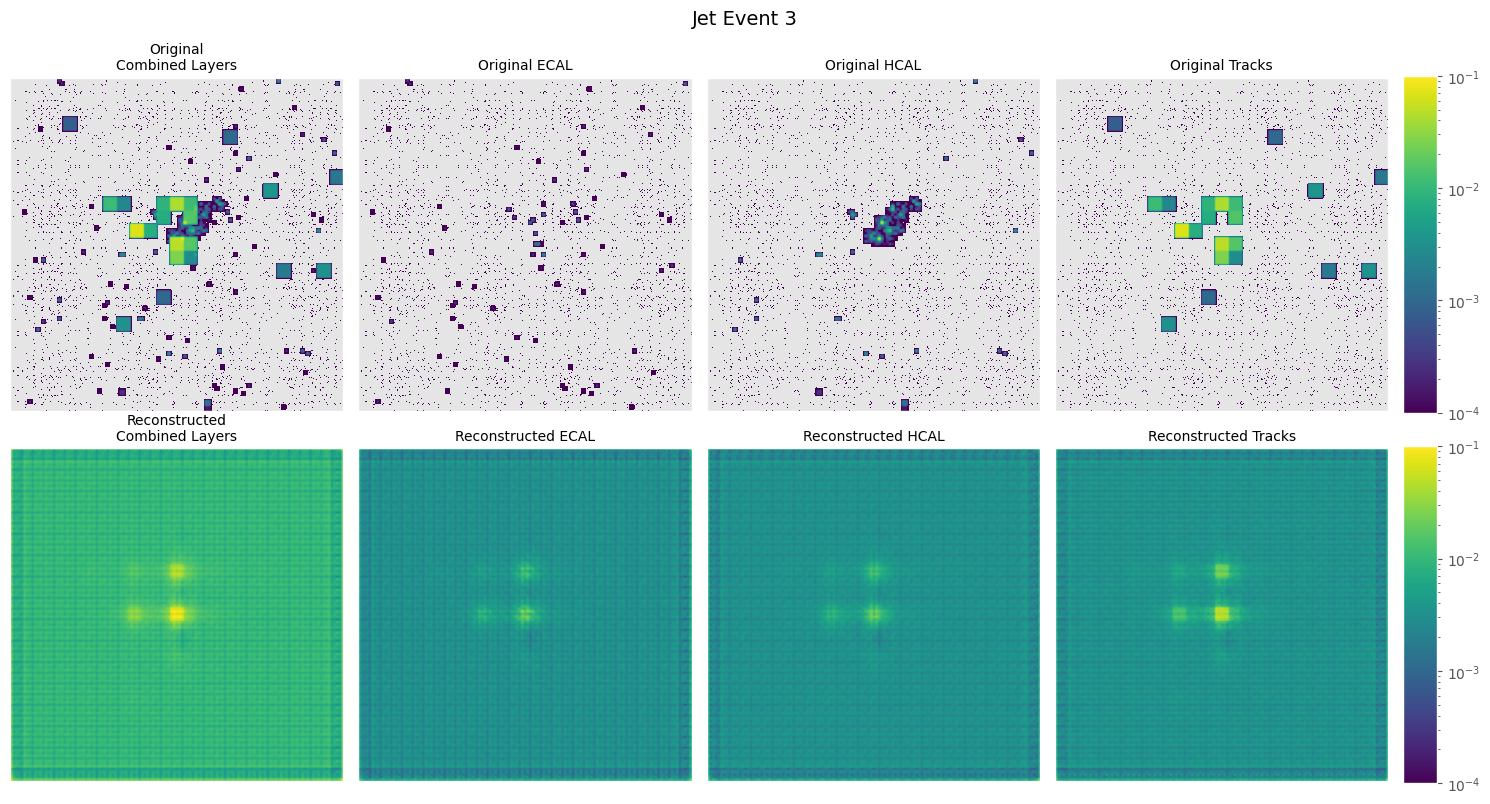

In [80]:
def plot_original_vs_reconstructed(original, reconstructed, n_samples=3):
    
    for i in range(n_samples):
        plt.figure(figsize=(15, 8))
        plt.suptitle(f'Jet Event {i+1}', y=1.0, fontsize=14)
        
        gs = plt.GridSpec(2, 5, width_ratios=[1,1,1,1,0.1], height_ratios=[1,1])
        
        # Original images
        ax1 = plt.subplot(gs[0, 0])  # Combined Original
        ax2 = plt.subplot(gs[0, 1])  # ECAL Original
        ax3 = plt.subplot(gs[0, 2])  # HCAL Original
        ax4 = plt.subplot(gs[0, 3])  # Tracks Original
        cax1 = plt.subplot(gs[0, 4])  # Colorbar
        
        # Reconstructed images
        ax5 = plt.subplot(gs[1, 0])  # Combined Reconstructed
        ax6 = plt.subplot(gs[1, 1])  # ECAL Reconstructed
        ax7 = plt.subplot(gs[1, 2])  # HCAL Reconstructed
        ax8 = plt.subplot(gs[1, 3])  # Tracks Reconstructed
        cax2 = plt.subplot(gs[1, 4])  # Colorbar

        # Calculate combined views
        combined_original = np.stack([original[i,0], original[i,1], original[i,2]], axis=-1).sum(axis=-1)
        combined_recon = np.stack([reconstructed[i,0], reconstructed[i,1], reconstructed[i,2]], axis=-1).sum(axis=-1)

        # Create normalization instance
        norm = LogNorm(vmin=1e-4, vmax=0.1)
        cmap = 'viridis'

        # Plot original images
        im1 = ax1.imshow(combined_original, cmap=cmap, norm=norm)
        ax1.set_title('Original\nCombined Layers', fontsize=10)
        
        im2 = ax2.imshow(original[i,0], cmap=cmap, norm=norm)
        ax2.set_title('Original ECAL', fontsize=10)
        
        im3 = ax3.imshow(original[i,1], cmap=cmap, norm=norm)
        ax3.set_title('Original HCAL', fontsize=10)
        
        im4 = ax4.imshow(original[i,2], cmap=cmap,norm=norm)
        ax4.set_title('Original Tracks', fontsize=10)

        # Plot reconstructed images
        im5 = ax5.imshow(combined_recon, cmap=cmap, norm=norm)
        ax5.set_title('Reconstructed\nCombined Layers', fontsize=10)
        
        im6 = ax6.imshow(reconstructed[i,0], cmap=cmap, norm=norm)
        ax6.set_title('Reconstructed ECAL', fontsize=10)
        
        im7 = ax7.imshow(reconstructed[i,1], cmap=cmap, norm=norm)
        ax7.set_title('Reconstructed HCAL', fontsize=10)
        
        im8 = ax8.imshow(reconstructed[i,2], cmap=cmap, norm=norm)
        ax8.set_title('Reconstructed Tracks', fontsize=10)

        # Add colorbars
        plt.colorbar(im1, cax=cax1)
        plt.colorbar(im5, cax=cax2)

        # Remove axes ticks
        for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

def image_reconstruction(model, data, n_samples=3):
    model.eval()
    indices = np.random.choice(len(data), n_samples, replace=False)
    samples = data[indices].to(device)
    
    with torch.no_grad():
        reconstructions = model(samples).cpu().numpy()
    
    samples = samples.cpu().numpy()

    plot_physics_style(samples, reconstructions, n_samples=n_samples)

image_reconstruction(model, val_data)